## Конфигурация 

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import re

import pymorphy2
import nltk
from tqdm import tqdm

import sys
def add_sys_path(p):
    if p not in sys.path:
        sys.path.append(p)
add_sys_path(os.path.dirname(os.getcwd()))

from test_problem import util

In [2]:
INPUT_ROOT = os.path.join('..','INPUT')

In [90]:
w2v_fpath = os.path.join(r"C:\Users\ddale\Downloads\mv", "all.norm-sz100-w10-cb0-it1-min100.w2v")
import gensim
w2v = gensim.models.KeyedVectors.load_word2vec_format(w2v_fpath, binary=True, unicode_errors='ignore')
w2v.init_sims(replace=True)

C:\Users\ddale\AppData\Local\Continuum\Anaconda3\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [10]:
import pickle
import os
import pymorphy2

class SmartLemmatizer:
    def __init__(self, cache_file):
        self.cache = dict()
        self.morph = pymorphy2.MorphAnalyzer()
        self.cache_file = cache_file
        if os.path.isfile(self.cache_file):
            with open(self.cache_file, 'rb') as file:
                self.cache = pickle.load(file)
    def get_nf(self, word):
        if word in self.cache:
            return self.cache[word]
        else:
            parsed = self.morph.parse(word)
            normal_form = parsed[0].normal_form
            self.cache[word] = normal_form
            return normal_form
    def save(self):
        with open(self.cache_file, 'wb') as file:
            pickle.dump(self.cache, file)

In [12]:
sl = SmartLemmatizer(os.path.join(INPUT_ROOT, 'lemmas.pkl'))
print(sl.get_nf('зебры'))
print(sl.cache)

зебра
{'зебры': 'зебра'}


In [47]:
from hunspell import Hunspell
h =  Hunspell("Russian-English Bilingual", hunspell_data_dir = r'C:\Users\ddale\Downloads\mv\CyHunspell-1.2.0\dictionaries')

In [94]:
voc = set(w2v.index2word)
len(voc)

1239964

Смотрим, что не может векторизовать сеть

In [134]:
t = util.tokenize(text_by_product.sample(1).total_text.iloc[0])
for w in set(t):
    w = w.replace('ё', 'е')
    nf = sl.get_nf(w)
    if w not in voc and nf not in voc:
        print(w, sl.get_nf(w))
        print([c for c in h.suggest(w) if [sub for sub in c.split() if sub in voc] ])

******* *******
[]
*** ***
[]
Еще ещё
['Ещ е']
нагревается…При нагревается…переть
['переваривается']


## Загрузка, предобработка отзывов

In [124]:
d1 = pd.read_csv(os.path.join( INPUT_ROOT, 'dataset1.csv'), index_col=0)
print(d1.shape)
d1.head(3)

(270941, 15)


,PRODUCT,CATEGORY_ID,BRAND_ID,CATEGORY_NAME,BRAND_NAME,TYPE,SUBJECT,TEXT,POSTED_DATE,RATING,BENEFITS,DRAWBACKS,RECOMMENDED,LIKES_COUNT,DISLIKES_COUNT
0,30024724,2060202,1900,PRINTERS LASER,Kyocera,REVIEW,NaN,Что особенно ценно - при профилактике принтера...,23.10.16 22:26:00,5.0,"хорошая скорость печати, двусторонняя печать, ...","Рядом ""на стол"" не поставишь, место много зани...",1.0,2.0,0.0
1,30024724,2060202,1900,PRINTERS LASER,Kyocera,REVIEW,NaN,Он у нас три месяца в офисе стоит уже - большо...,17.04.16 11:17:42,5.0,NaN,NaN,NaN,0.0,2.0
2,30024725,2060202,1900,PRINTERS LASER,Kyocera,REVIEW,NaN,"Просто небо и земля с тем принтером, который у...",15.04.16 20:22:47,4.0,NaN,NaN,NaN,0.0,1.0


Запускаю лемматизацию всех отзывов. 

In [5]:
l = []
for text in tqdm(d1.TEXT):
    l.append(' '.join(util.lemmatize(util.tokenize(util.replace_smiles(text)))))
d1['TEXT_prepared'] = l

100%|█████████████████████████████████████████████████████████████████████████| 270941/270941 [08:57<00:00, 504.36it/s]


In [151]:
l = []
for text in tqdm(d1.SUBJECT.fillna('')):
    l.append(' '.join(util.lemmatize(util.tokenize(util.replace_smiles(text)))))
d1['SUBJECT_prepared'] = l

100%|████████████████████████████████████████████████████████████████████████| 270941/270941 [00:49<00:00, 5467.26it/s]


In [152]:
l = []
for text in tqdm(d1.BENEFITS.fillna('')):
    l.append(' '.join(util.lemmatize(util.tokenize(util.replace_smiles(text)))))
d1['BENEFITS_prepared'] = l

100%|████████████████████████████████████████████████████████████████████████| 270941/270941 [00:36<00:00, 7499.66it/s]


In [153]:
l = []
for text in tqdm(d1.DRAWBACKS.fillna('')):
    l.append(' '.join(util.lemmatize(util.tokenize(util.replace_smiles(text)))))
d1['DRAWBACKS_prepared'] = l

100%|████████████████████████████████████████████████████████████████████████| 270941/270941 [00:29<00:00, 9248.25it/s]


In [936]:
d1[['TEXT_prepared', 'SUBJECT_prepared', 'BENEFITS_prepared', 'DRAWBACKS_prepared']].to_pickle(
    os.path.join(INPUT_ROOT, 'prepared_texts.pickle'))

In [127]:
tmp = pd.read_pickle(os.path.join(INPUT_ROOT, 'prepared_texts.pickle'))
for c in tmp.columns:
    d1[c] = tmp[c]

In [128]:
prod2categ = d1.CATEGORY_ID.groupby(d1.PRODUCT).aggregate(lambda x:x.value_counts().index[0])

In [129]:
categ2name = d1.CATEGORY_NAME.groupby(d1.CATEGORY_ID).aggregate(lambda x:x.value_counts().index[0])

In [10]:
d1[['SUBJECT','TEXT', 'BENEFITS','DRAWBACKS', 'RECOMMENDED', 'RATING', 'TEXT_prepared']].sample(1).squeeze().to_dict()

{'BENEFITS': nan,
 'DRAWBACKS': nan,
 'RATING': 5.0,
 'RECOMMENDED': nan,
 'SUBJECT': 'Все нравится, диск качественный',
 'TEXT': 'По мне так этот аппарат стоит своих денег, у него не только высокие скорости передачи и чтения файлов за счет 3.0 интерфейса, но еще и полная защита от всех возможных проблем с файлами, воды не боится, влаги тоже, как и ударов, тут вообще один из слоев упругий, падения амортизируются им. Памяти куча, хранилище из него отличное',
 'TEXT_prepared': 'по я так этот аппарат стоить свой деньга , у он не только высокий скорость передача и чтение файл за счёт 3.0 интерфейс , но ещё и полный защита от весь возможный проблема с файл , вода не бояться , влага тоже , как и удар , тут вообще один из слой упругий , падение амортизироваться имя . память куча , хранилище из он отличный'}

In [130]:
ps = '\n***\n'
d1['total_text'] = (d1['SUBJECT'].fillna('') + ps + d1['TEXT'].fillna('') + ps + d1['BENEFITS'].fillna('') 
                    + ps + d1['DRAWBACKS'].fillna(''))

In [131]:
d1['total_text_prepared'] = (d1['SUBJECT_prepared'].fillna('') + ps + d1['TEXT_prepared'].fillna('') + ps 
                             + d1['BENEFITS_prepared'].fillna('') + ps + d1['DRAWBACKS_prepared'].fillna(''))

In [181]:
print(d1['total_text_prepared'].sample(1).values[0])

вопрос ?
***
народ , а он у я почему-то сам перезагружаться , только что купить , сказать , пожалуйста , так и должный быть , или это глюк в он какой-нибудь ? ? ? ?
***

***



Склеиваем отзывы по одному продукту

In [132]:
rs = '\n*******\n'
text_by_product = d1[['total_text', 'total_text_prepared']].groupby(d1['PRODUCT']).aggregate(lambda x : rs.join(x))
text_by_product.shape

(36475, 2)

In [190]:
print(text_by_product.sample(1).values[0])

[ 'BEKO DIS 5831\n***\nПользуюсь 4 месяца. Покупали к рождению ребенка, чтобы облегчить себе жизнь. Да, современная бытовая техника позволяет вздохнуть с облегчением. Итак:\n1) обычно пользуемся программой №7 (2часа), т.к. с ней очень хорошо промывается все,в том числе и бутылки для детского питания. Реже используем программу №5 (58 мин) - когда нет особо грязной или засохшей посуды.\n2) Советую, чтоб потом не жаловаться на пятна, правильно настроить дозатор кондиционера.\n3) После мойки советую машину открыть (или приоткрыть - если не собираетесь доставать посуду) минут на 5-10, посуда горячая, и так она вся обсохнет.\n4) При мойке ночью  шумновато. Хотя днем нормально.\n    Как она мое - это просто сказка. Такой наша посуда была только в день покупки. Руками так никогда не отмыть.Не машина - праздник.\n***\n\n***\n\n*******\nРекомендую!\n***\nОтличная машинка. Даже не ожидала, что так отлично будет отмывать посуду. Стаканы, тарелки, ложки, банки, сковородки - идеально чисто даже без 

In [191]:
text_by_product.columns

Index(['total_text', 'total_text_prepared'], dtype='object')

In [251]:
def add_bigrams_to_text(text):
    return ' '.join(util.add_bigrams(util.tokenize(text)))

In [256]:
text_by_product.columns

Index(['total_text', 'total_text_prepared'], dtype='object')

In [258]:
text_by_product['text_bigram'] = text_by_product['total_text'].apply(add_bigrams_to_text)
text_by_product['prep_bigram'] = text_by_product['total_text_prepared'].apply(add_bigrams_to_text)

In [766]:
text_by_product.to_pickle(os.path.join(INPUT_ROOT, 'joined_reviews.pickle'))

In [133]:
text_by_product = pd.read_pickle(os.path.join(INPUT_ROOT, 'joined_reviews.pickle'))

Смотрим, сколько раз каждое слово встречается

In [235]:
from collections import Counter
counters = []
for text in tqdm(text_by_product['total_text_prepared']):
    counters.append(Counter(util.tokenize(text)))

100%|███████████████████████████████████████████████████████████████████████████| 36475/36475 [05:40<00:00, 107.18it/s]


In [762]:
total_counter = Counter()
for c in tqdm(counters):
    total_counter += c

100%|████████████████████████████████████████████████████████████████████████████| 36475/36475 [11:37<00:00, 52.29it/s]


In [239]:
from collections import Counter
total_df = Counter()
for c in tqdm(counters):
    for w in c:
        total_df[w]+=1

100%|██████████████████████████████████████████████████████████████████████████| 36475/36475 [00:05<00:00, 7043.85it/s]


In [241]:
print(len(total_df), len(total_counter))

252464 252464


In [764]:
import pickle

In [765]:
with open('total_counter.pkl', 'wb') as file:
    pickle.dump(total_counter, file)

In [ ]:
with open('total_df.pkl', 'wb') as file:
    pickle.dump(total_df, file)

## Разпикливаем всё

In [13]:
with open('total_counter.pkl', 'rb') as file:
    total_counter = pickle.load(file)

In [ ]:
with open('total_df.pkl', 'rb') as file:
    total_df = pickle.load(file)

## Гипотеза 1: tf-idf 

Как отрабатывает на товаре vs все? Плохо

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [60]:
vec = TfidfVectorizer(min_df = 3, max_df = 0.95)

In [192]:
vec.fit(text_by_product['total_text_prepared'])
print(len(vec.vocabulary_))

50098


In [265]:
categ2tfidf = dict()
for categ in set(prod2categ.values):
    categ_sample = text_by_product[prod2categ[text_by_product.index]==categ]
    try:
        categ2tfidf[categ] = TfidfVectorizer(min_df = 3, max_df = 0.95).fit(categ_sample['prep_bigram'])
    except ValueError:
        print(categ2name[categ], ' is to small', categ_sample.shape)

FAXES                                       is to small (2, 4)
IONIZER                                     is to small (2, 4)
DEHUMIDIFIER                                is to small (1, 4)
OLED-TV 40\" - 55\"                         is to small (1, 4)
ACCESSORIES FOR NINTENDO WII                is to small (1, 4)
COMPACT PHOTOPRINTERS                       is to small (1, 4)
OTHERS TELECOMMUNICATION PRODUCTS           is to small (1, 4)
AUDIO/CD RECORDED                           is to small (3, 4)
XEROX                                       is to small (3, 4)
OTHERS TELECOMMUNICATIONS                   is to small (2, 4)
PHONE ADDITIONAL DEVICES                    is to small (3, 4)
ELECTRONIC DICTIONARIES                     is to small (1, 4)
AUDIOBOOKS                                  is to small (3, 4)
3D DIGITAL CAMERAS                          is to small (1, 4)
NEW PLANNAME PHOTO-AUTO 6                   is to small (1, 4)
PHOTO PRINTING                              is to small

In [203]:
sample = text_by_product.sample(1)
tmp = vec.transform(sample['total_text_prepared']).todense()
tmp[tmp<0.1] = 0
print(vec.inverse_transform(tmp)[0])
print(sample['total_text'].values[0])

['combo' 'keyboard' 'logitech' 'russian' 'wireless' 'батарейка' 'клава'
 'клавиатура' 'кнопка' 'колесико' 'комплект' 'мышь' 'не' 'передатчик'
 'планшет' 'язык']

***
с расстояния в три метра клава ну просто отказывается реагировать на мои нажатия на кнопки. сейчас пишу с расстояния в 1 метр - прием удовлетворительный!!!
скорее всего, завтра пойду менятьь на что-то постабильней!
***
мышь,.  вврродее бы,. ничего
***
клава -  отвратительна!!!
*******
Комплект клавиатура+мышь Logitech Wireless Combo MK220 
***
очень шумная клавиатура.
сливает по этому параметру конкуренту Genius SlimStar 8000ME НА ПОРЯДКИ, у того комплекта реально по сравнению с логитеком бесшумная клавиатура
***

***

*******
Смена языков
***
Языки при работе с андроидом меняются нажатием клавиш shift+пробел.
***

***

*******

***
покупайте у кого денег мало,  и надоели провода.
***
ДЕШЕВАЯ БЕСПРОВОДНАЯ КЛАВИАТУРА.Батарейки  НАДОЛГО ХВАТАЕТ
***
нет
*******

***
Купил 09.12.2016 для самсунг смарт тв дак он её вообще нехоч

Как отрабатывает на товаре vs категория? Чуть лучше

0.14284264945632416

In [305]:
sample = text_by_product.sample(1)

categ = prod2categ[sample.index[0]]
print(categ, categ2name[categ])
# все тексты об этой категории
if categ in categ2tfidf:
    vec0 = categ2tfidf[categ]
    #categ_sample = text_by_product[prod2categ[text_by_product.index]==categ]
    #vec.fit(categ_sample['total_text_prepared'].apply(add_bigrams_to_text))
    tmp = vec0.transform(sample['total_text_prepared'].apply(add_bigrams_to_text)).todense()
    threshold = sorted(np.array(tmp)[0],reverse=True)[5]
    tmp[tmp<threshold] = 0
    print(vec0.inverse_transform(tmp)[0])
    print(sample['total_text'].values[0])
else:
    print('too small categ')

4130401 HAIR CARE                                 
['волос' 'для_завивка' 'если_использовать' 'утюжок' 'утюжок_на' 'шнур_в']

***
У меня волосы пушистые и тонкие, укладывать их трудно. А этот утюжок на удивление легко справился с беспорядком у меня на голове. Понравилось, что корпус имеет скругления, удобно, если используешь утюжок для завивки. 
***
Удобный, быстро нагревается, можно использовать и для выпрямления, и для завивки.
***
Туговаты кнопки для переключения температуры
*******

***
Хотелось себе именно качественный выпрямитель, который нормально работает и при этом не испортит мои волосы. Вьющиеся волосы не мое, поэтому пользуюсь им часто. И всегда прическа сохраняется долго. Нравится, что им нельзя сжечь волосы. Кстати, он еще и завивает, поэтому даю иногда сестре, она наоборот очень хочет вьющиеся волосы.
***
Отлично и надолго выпрямляет, не жжет кончики, турмалиновое покрытие, наличие 8 режимов
***
Не нахожу
*******

***
Вчера опробовала этот утюжок на своих волосах. Разгла

# Гипотеза 2: любимые комменты

если какой-то отзыв лайкают, то он полезен. Но можем ли мы предсказать, какие отзывы залайкают? не очень 

In [307]:
d1[['LIKES_COUNT','DISLIKES_COUNT']].describe()

,LIKES_COUNT,DISLIKES_COUNT
count,261987.000000,261987.000000
mean,12.077347,7.512342
std,43.402505,31.594347
min,0.000000,0.000000
25%,1.000000,0.000000
50%,5.000000,2.000000
75%,13.000000,7.000000
max,11048.000000,10207.000000


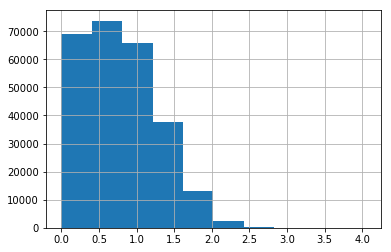

In [309]:
np.log10(1+d1.LIKES_COUNT).hist()

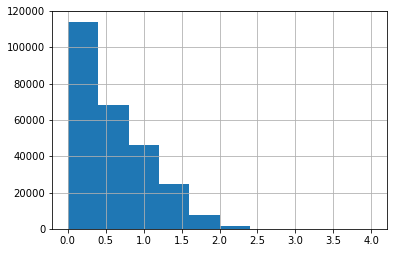

In [310]:
np.log10(1+d1.DISLIKES_COUNT).hist()

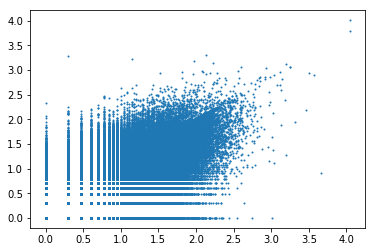

In [312]:
plt.scatter(np.log10(1+d1.LIKES_COUNT), np.log10(1+d1.DISLIKES_COUNT), s = 1)

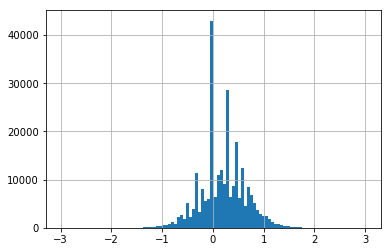

In [314]:
likeness = np.log10(1+d1.LIKES_COUNT)- np.log10(1+d1.DISLIKES_COUNT)
likeness.hist(bins=100)

Пытаемся предсказать, насколько рейтинг понравится людям. 

Понимаем, что топ признаков в получившейся модели - бессмысленные. Видим, что, кажется, люди не очень любят критику, но и только. 

In [324]:
y = likeness.fillna(0)
x = d1['total_text_prepared']
print(x.shape, y.shape)

(270941,) (270941,)


In [320]:
from sklearn.model_selection import cross_val_score, cross_val_predict, TimeSeriesSplit, KFold
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import r2_score

In [340]:
pipe_tf = TfidfVectorizer(min_df=10, ngram_range=[1,2]).fit(x)
pipe_x = pipe_tf.transform(x)
print(pipe_x.shape)

(270941, 204661)


In [341]:
#pipe = make_pipeline(TfidfVectorizer(min_df=3), Ridge(1))
cross_val_score(Ridge(10), pipe_x, y, cv= KFold(2, shuffle=True, random_state=1), n_jobs=-1)

array([ 0.09723266,  0.09403676])

In [351]:
reg = Ridge(10).fit(pipe_x, y)

In [353]:
inv_idx = {value:key for key, value in pipe_tf.vocabulary_.items()}
c = reg.coef_
best = [inv_idx[i] for i in np.argsort(c)[-20:]]
worst = [inv_idx[i] for i in np.argsort(c)[:20]]
print(', '.join(best))
print(', '.join(worst))

выше, тихо, haier, складный, читать, плеер, измельчать, _smile_positive, нетбук, единственный, отличный блендер, mkv, действительно, недостаток, не пожалеть, отзыв, комбайн, отличный, шедевр, блендер
мнение новинка, новинка, xiaomi, про acer, kitchenaid, не советовать, отзыв про, acer, не понравиться, трансформер, ужасный, ноутбук трансформер, разочарование, отстой, мнение, не стоить, разочаровать, redmi, 4a, 4к


А если предсказывать, какое внимание привлечёт отзыв? Это получается чуть лучше, но в целом тоже довольно плохо. 

Отзывы, где чего-то "не обнаружили" или "не выявили", не интересные. 

In [346]:
y0 = np.log10(1+d1.LIKES_COUNT + d1.DISLIKES_COUNT).fillna(0)

In [347]:
cross_val_score(Ridge(10), pipe_x, y0, cv= KFold(2, shuffle=True, random_state=1), n_jobs=-1)

array([ 0.15613324,  0.15704231])

In [348]:
reg = Ridge(10).fit(pipe_x, y0)

In [350]:
inv_idx = {value:key for key, value in pipe_tf.vocabulary_.items()}
c = reg.coef_
best = [inv_idx[i] for i in np.argsort(c)[-20:]]
worst = [inv_idx[i] for i in np.argsort(c)[:20]]
print(', '.join(best))
print(', '.join(worst))

psp, nokia, недостаток, оценка, айфон, блендер, борк, samsung, приставка, аппарат, телевизор, iphone, haier, bosch, apple, консоль, nbsp, новинка, отзыв, bork
нет, эксперт, не обнаружить, чехол, не найти, заряжать, прочный, обнаружить, 2017, не выявить, эксперт видео, год, выявить, подойти, салфетка, компактность, ответ эксперт, зуб, защищать, отзыв про


Вывод: предсказывать лайкабельность сложно, и, наверное, результаты не очень полезные. 

# Части речи в отзывах 

In [358]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [370]:
tag = morph.parse('защищать')[0].tag
print(tag)

INFN,impf,tran


In [ ]:
tag

In [379]:
import re

In [380]:
re.split('\W+', 'Words, words, words.')

['Words', 'words', 'words', '']

In [136]:
sample = text_by_product.sample(1)
text = sample['total_text'].values[0]
print(text)


***
Глючное железо, имеется несколько моделей. У всех проблемы с сетью и HDD.
Сервисная поддержка ASUS ужасна!
***
Производительный
***
Очень плохая реализация по железу. При нагреве много ошибок
*******

***
Драйвера на видеокарту конфликтуют с системой. В процессе работы или просмтра видео может перезагрузитья, либо вообще зависнуть Пришлось их удалить, после чего игровой ноутбук стал бюджетным. И помочь удаленно не могут, только в сервис. В плюсе только Сабвуфер, звук норм. 
***
САБВУФЕР
***
Видеокарта
*******

***
По заявленным характеристикам и соотношения цена ему нет равных, купил год назад, в результате поменяли 2 бука после постоянных зависаний видеокарты и тормозов жесткого диска, не третьем обмене просто плюнул на  эту модель вместе с asus. Третий бук работает, но переодически появляются артефакты и глюки на экране при серфинге интерактивных страниц. 
***
Хорошая батарея, дизайн корпус металл, средняя толщина, хороший full HD экран
***
нет подсветки клавиатуры, постоянные л

разбиение на подпредложения:
* справа и слева есть глагол (не инфинитив) [и существительное / местоимение] (сущ перед глаг), либо "существительное прилагательное"
* большая буква
* скобки
* разделители:
    * и
    * так как, то что, 
    * " - ", ":"
* выкинуть все вводные конструкции

In [540]:
def split_reviews(text):
    """ Takes one joint review and splits it into 
    """
    sents = [c.strip() for c in re.split('[\n\*,\.\!\(\)]', text) if len(c) > 3]
    ans = []
    for sent in sents:
        ans.append(sent)
        if len(sent) > 40:
            for d in ')', '(', ';', '-', ':':
                if d in sent:
                    for c in sent.split(d):
                        if len(c) > 3:
                            ans.append(c)
            for d in ['и', 'хотя', 'но', 'a']:
                d = ' '+d+' '
                if d in sent:
                    for c in sent.split(d):
                        if len(c) > 3:
                            ans.append(c)
    return ans

In [279]:
def split_into_words(text):
    words =  re.sub('[^a-zA-Zа-яА-Я]+', ' ', text).split()
    return [w for w in words if len(w)>3]

In [541]:
sents = split_reviews(text)
#sents

Цель - попробовать сгруппировать похожие предложения

In [170]:
from num2t4ru import num2text
num2text(100500)

'сто тысяч пятьсот'

In [171]:
from num2t4ru import num2text

# set('0123456789')
# todo: strip small letters from numbers, like 5-и, 5м

def insert_numbers(words):
    ans = []
    for word in words:
        if word.isdigit():
            ans = ans + util.tokenize(num2text(int(word)))
        else:
            ans.append(word)
    return ans
print(insert_numbers(util.tokenize('5 метровый кабель')))

['пять', 'метровый', 'кабель']


In [172]:
def space_after_digits(word):
    digits = set('0123456789')
    ans = ''
    prev_is_digit = False
    for letter in word:
        is_digit = (letter in digits)
        if prev_is_digit and not is_digit:
            ans = ans + ' '
        ans = ans + letter
        prev_is_digit = is_digit
    return ans
space_after_digits('5-и метровый кабель')

'5 -и метровый кабель'

In [173]:
def replace_punct(word):
    for symbol in r'-/:;':
        word = word.replace(symbol, ' ')
    return word

In [174]:
def longest(words):
    """ Returns the longest word
    """
    if ' ' not in words:
        return words
    words = words.split()
    l = 0
    ans = ''
    for word in words:
        l0 = len(word)
        if l0 > l:
            l = l0
            ans = word
    return ans
print(max_part('какбы'), max_part('как бы'))

какбы как


In [691]:
# todo: веса, обратно пропорциональные частотности

vocab = set(w2v.index2word)

from hunspell import Hunspell
h =  Hunspell("Russian-English Bilingual", hunspell_data_dir = r'C:\Users\ddale\Downloads\mv\CyHunspell-1.2.0\dictionaries')

def sent2words(sent):
    return util.lemmatize(insert_numbers(util.tokenize(space_after_digits(replace_punct(sent)))))

def sent2vec(words, verbose = False):
    """ Turns sentence into a vector
        Requires an instance of w2v gensim model and an instance of total_counter
    """
    #print(words)
    total = np.zeros(w2v.syn0.shape[1])
    weights = 1e-4
    for word in words:
        word = word.replace('ё', 'е').strip()
        if word not in vocab:
            if verbose:
                print(word, 'not in vocab', end = ' ')
            suggestions = []
            try:
                suggestions = [longest(c) for c in h.suggest(word)]
            except MemoryError:
                pass
                # continue silently
            suggestions = [c for c in suggestions if c in vocab]
            if verbose:
                    print(suggestions)
            if suggestions:
                word = suggestions[0]
        if word in vocab:
            v = w2v.word_vec(word)
            # часто глобально встречающиеся слова мы взвешиваем вниз
            w = 1 #/ np.sqrt(1+total_df[word])
            total = total + v
            weights = weights + w
        else:
            pass
    ans = total / weights
    return ans / np.sqrt(sum(ans**2)+1e-4)

In [255]:
vecs = [sent2vec(sent, verbose = False) for sent in sents]
vecmat = pd.DataFrame(vecs).fillna(0)
vecmat.shape

(465, 100)

In [256]:
mat = vecmat.transpose().corr()
mat.shape

(465, 465)

In [322]:
def get_trigrams(lemmas):
    return [w1+'_'+w2+'_'+w3 for w1, w2, w3 in zip(lemmas[:-2], lemmas[1:-1], lemmas[2:])]

In [754]:
from sklearn.cluster import DBSCAN, MeanShift, KMeans

rs = '\n*******\n'

def bt(review):
    seq = util.tokenize(space_after_digits(replace_punct(re.sub('[^a-zA-Zа-яА-Яё]+', ' ', review))))
    arr = util.get_bigrams(seq) + get_trigrams(seq)
    return [a.replace('_', ' ') for a in arr]

def extract_facts(joined_reviews, verbose = False, eps = 0.3, grams = False, censor = True):
    # split big review into different reviews and those into facts
    reviews = joined_reviews.split(rs)
    
    if grams:
        sents2_raw = [bt(review)  for review in reviews]
    else:
        sents2_raw = [split_reviews(review)  for review in reviews] # + bt(review)
    sents2 = [[sent2words(r) for r in review] for review in sents2_raw]
    #print(len(sents2_raw), len(sents2))
    #seqs = [util.lemmatize(split_into_words(review)) for review in reviews]
    #sents2 = [util.get_bigrams(seq) + get_trigrams(seq) for seq in seqs]
    #sents2 = [[sent.split('_') for sent in sents] for sents in sents2 ]
    
    
    sents_flat = [sent for sents in sents2 for sent in sents]
    id2doc = [i for i, sents in enumerate(sents2) for sent in sents]
    vecs = [sent2vec(sent) for sents in sents2 for sent in sents]
    
    #print(sents_flat)
    #print([' '.join(s) for s in sents_flat])
    
    vecmat = pd.DataFrame(vecs).fillna(0)
    clu = DBSCAN(min_samples=2, eps=eps, p=2)
    #clu = MeanShift(bandwidth=eps)
    #clu = KMeans(n_clusters=5)
    result = clu.fit_predict(vecmat)
    if verbose:
        print(result)
    s2 = pd.Series(sents_flat)
    who2 = pd.Series(id2doc)
    
    sents_raw_flat = pd.Series([sent for sents in sents2_raw for sent in sents])
    
    candidates = dict()
    representatives = dict()
    
    for ur in np.unique(result[result>=0]):
        fltr = result==ur
        if sum(fltr) == 1 or sum(fltr) > 30:
            # too small or too large a cluster
            continue
        if who2[fltr].std() < 1e-5 and censor:
            # only one source
            continue
        if verbose:
            print()
            print(sum(fltr), who2[fltr].var())
        candidates[ur] = 0
        min_dist = np.inf
        representative = 'ERROR'
        center = vecmat[fltr].mean()
        for sent, vec, raw in zip(s2[fltr], vecmat[fltr], sents_raw_flat[fltr]):
            if verbose:
                print('\t', ' '.join(sent).strip())
            # accumulate total tf-idf
            cand_weight = sum([1 / np.log(1.01 + total_counter[word]) * (total_df[word]>1) * len(word)  for word in sent])
            candidates[ur] += cand_weight
            dist = sum((center - vec)**2)*0.5 / cand_weight
            if dist < min_dist:
                min_dist = dist
                representative = raw
        representatives[ur] = representative
        
    result = pd.concat([pd.Series(representatives), pd.Series(candidates)], axis = 1)
    result.columns = ['center', 'importance']
    result.sort_values('importance', ascending = False, inplace = True)
    return result

In [708]:
sample = text_by_product.sample(1)

In [709]:
text = sample['total_text'].values[0]
#print(text)
print(len(text))
extract_facts(text, True, 0.4).values

3707
[[], ['СУПЕР ТЕЛЕФОН'], ['хорошей смартфон', 'красивый', 'царапается'], ['Служит мне уже полтора года', 'телефон замечательный', 'при ежедневном активном использовании нисколько не просел по производительности - система работает так же как и при покупке быстро и без глюков', 'при ежедневном активном использовании нисколько не просел по производительности ', ' система работает так же как и при покупке быстро и без глюков', 'при ежедневном активном использовании нисколько не просел по производительности - система работает так же как', 'при покупке быстро', 'без глюков', 'Фотокамеры неплохие', 'Чехлы на алиэкспресс можно заказать', 'их куча', 'Но огромный минус - это батарея', 'Разряжается он быстро', 'Ну конечно если вы часами не смотрите сериалы и тд то этот телефон самое то', 'Ну конечно если вы часами не смотрите сериалы', 'тд то этот телефон самое то'], ['Очень солидный аппарат на пятом андроиде', 'взял сразу два таких - себе и жене', 'удобно', 'что можно одновременно две симки 

array([['телефон замечательный', 3.5237989213570446],
       ['КАМЕРА', 1.1946669747901917]], dtype=object)

In [694]:
print(text)

Хороший телефон
***
Купил этот телефон в М.Видео еще в ноябре в интернет магазине. Аппаратом в целом доволен. 
1) Отличный экран
2) Качественная сборка
3) Качественные материалы изготовления (металл, стекло)
4) Отличная визуализация интерфейса операционной системы, превосходный мультитач
5) Потрясающая фотокамера
6) Быстрая скорость работы за счёт шустрого процессора, отсутствие зависаний
***

***

*******
Apple iPhone4
***
Приобрела это чудо!!!
И довольна им!
Больше всего понравилась быстрая скорость за счёт шустрого процессора,не зависает.Один минус долго вникала что к чему)
***

***

*******
Отстой полный...
***
Далеко не стоит своей цены. Экран LCD очень стар по сегодняшним меркам. ОС закрытого типа не дает ничего сделать, ни по блютузу музыку и фотки перекинуть, ни посмотреть фильм в нормальном формате, к примеру MKV. А чего стоит iTunes... Это просто хлам.
***

***

*******
Отличный телефон
***
Так как обожаю технику Apple приобрела данный телефон.
Обожаю его. Отличный дизайн, хо

# new data

In [789]:
d_new = pd.read_csv('proba_1_v5.csv', index_col=0)
print(d_new.shape)
d_new.head(3)

(1539, 16)


,PRODUCT,NAME,CATEGORY_ID,BRAND_ID,CATEGORY_NAME,BRAND_NAME,TYPE,SUBJECT,TEXT,POSTED_DATE,RATING,BENEFITS,DRAWBACKS,RECOMMENDED,LIKES_COUNT,DISLIKES_COUNT
0,20025017,Морозильная камера Liebherr G 1213-20 ...,4020301,313,FREEZERS,Liebherr,review,NaN,"Небольшая симпатичная морозильная камера, нашл...",02.09.2013,4.0,NaN,NaN,0,30,26
1,20025017,Морозильная камера Liebherr G 1213-20 ...,4020301,313,FREEZERS,Liebherr,review,NaN,Пользуемся месяц. Искали недорогую маленькую м...,17.09.2017,5.0,низкая цена по сравнению с другими с такими же...,Пока не нашла,0,1,0
2,20025017,Морозильная камера Liebherr G 1213-20 ...,4020301,313,FREEZERS,Liebherr,review,NaN,"Морозилка хорошая, подошла по высоте кухонного...",25.08.2017,4.7,NaN,NaN,0,1,0


In [794]:
def apply_to_new_data(d1):
    ps = '\n***\n'
    d1['total_text'] = (d1['SUBJECT'].fillna('') + ps + d1['TEXT'].fillna('') + ps + d1['BENEFITS'].fillna('') 
                        + ps + d1['DRAWBACKS'].fillna(''))
    text_by_product = d1[['total_text']].groupby(d1['NAME']).aggregate(lambda x : rs.join(x))
    ans = dict()
    for key, value in text_by_product.iterrows():
        facts = extract_facts(value.values[0], True, 0.4).center
        if len(facts) == 0:
            facts = extract_facts(value.values[0], True, 0.4, False, False).center
        if len(facts) == 0:
            facts = extract_facts(value.values[0], True, 0.4, True, False).center
        val = '\n > '.join(['Пользователи пишут:']+list(facts.apply(lambda x: x.capitalize())))
        ans[key] = val
    return ans

In [795]:
tmp = apply_to_new_data(d_new)
print(tmp)

[-1  0  1  1  1 -1 -1 -1  2  1 -1 -1 -1 -1  3  4 -1  5  5  5  5  5  5  5 -1
 -1 -1 -1  6 -1 -1 -1  7 -1  7  8 -1 -1 -1  1  9  1 10 11 -1  6 12 -1 13 -1
 14  1 15 16 -1 -1  1 -1 -1 -1 16 -1 -1 -1 -1 17  8 18 19 20 21 22 23 24 17
  8 18 19 20 21 22 23 24 10 25 -1 -1 -1 -1 -1 26 -1 -1 -1  1 -1 -1 -1 -1 -1
  1  1 27 26 -1 -1 28 -1 -1 -1 -1  1  1 -1 29 -1 29  1 -1  1 -1  1  1 -1 -1
 -1 30 -1 -1  1  1  1 -1 -1 31 -1  1 -1 -1 -1 -1 -1  6 -1 -1 -1 32 16 -1 33
 34 -1 35 -1 -1 36 37 33 -1  1 -1 -1 -1 -1 -1  1  9  1 38 -1 38 -1 39 -1 -1
 40 -1 40 40 -1 20 -1 -1 -1 41 41 41 -1 -1 -1 -1  1 -1 -1 -1 -1  1  1 -1 -1
 -1 -1 -1 -1 -1 42 -1 -1 -1 -1 43 39 43 43 -1  1 -1 -1 -1 -1 -1 -1 -1 44 44
 44 -1  1 -1 -1 45 45 -1 -1 -1 46 -1 -1  1 -1  8 -1 47 47 -1 32 36 37 -1 10
 -1 -1 -1 -1  1  3  4 -1 -1  1 -1  1  1  1 -1 32 48 -1 -1 -1 -1 -1 -1 49 -1
  8  1 -1  1 -1 27  8  1 -1 50 50 -1  1  1 -1 -1  1 -1 -1  1  1 -1 51  1 -1
 -1  1 -1  1  1  1 31 -1 -1 31 52 53 -1  0 54 53 55  1 -1 -1 -1 -1  1  1 -1
 56 -1 56 -1

C:\Users\ddale\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in double_scalars


C:\Users\ddale\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars


	 
	 
	 liebherr

3 310.3333333333333
	 хорошо морозить
	 морозить хорошо
	 морозить отлично

2 84.5
	 разместить в коридор вписаться идеально
	 идеально вписаться в интерьер кухня

2 50.0
	 морозилка довольный как слон
	 довольный как слон

4 147.58333333333334
	 работать бесшумно
	 работать бесшумно
	 работать бесшумно
	 работать бесшумно

3 8.333333333333334
	 несмотря на маленький размер морозильный камера ящик в она очень вместительный
	 ящик очень объ мный и морозилка вместить практически весь продукт из большой морозильный камера холодильник
	 морозилка вместить практически весь продукт из большой морозильный камера холодильник

2 18.0
	 удобный
	 удобный

2 0.5
	 стильный и компактный морозильный камера
	 компактный морозильный камера

2 60.5
	 быстро доставить
	 доставить быстро

2 450.0
	 быстро замораживать овощ и ягода
	 заморозить быстро ягода и фрукт

3 300.0
	 кондиционер в сравнение с морозилка более шумный
	 особенно в сравнение с холодильный камера liebherr
	 особенно

	 небо
	 небо

2 0.5
	 очень понравиться клавиатура с с регулировать подсветка
	 очень понравиться клавиатура с с регулировать подсветка

3 4.333333333333334
	 и прекрасный экран
	 и прекрасный экран
	 прекрасный экран

2 0.5
	 глубина цветок на наш метр превосходный
	 глубина цветок на наш метр превосходный

2 0.5
	 фотограф обязательно понравиться
	 фотограф обязательно понравиться

2 0.5
	 стоить отметить трекпад дать модель
	 стоить отметить трекпад дать модель

2 0.5
	 твердотельный накопитель данный компьютер иметь превосходный скорость чтение запись
	 твердотельный накопитель данный компьютер иметь превосходный скорость чтение запись

2 0.5
	 установленный программа
	 установленный программа

2 0.5
	 что unix
	 что unix

2 0.5
	 что можно разобрать система по косточка
	 что можно разобрать система по косточка

2 0.5
	 соответственно нужно обладать определённый знание
	 соответственно нужно обладать определённый знание

2 0.5
	 радовать то
	 радовать то

2 0.5
	 что в appstore им

C:\Users\ddale\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in double_scalars


	 лагаета
	 


C:\Users\ddale\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars


	 
	 играбельный
	 
	 
	 играбельный
	 
	 
	 

4 894.9166666666666
	 греться
	 греться
	 греться
	 греться

2 84.5
	 также обращать ваш внимание
	 обращать ваш внимание

2 800.0
	 видео юлий
	 видео юлий

2 84.5
	 звук хороший
	 звук отличный

2 144.5
	 фпс
	 фпс

3 140.33333333333334
	 видео мария
	 видео анна
	 видео анна

2 18.0
	 в интернет
	 в соцсеть

2 512.0
	 удобно брать с себя
	 не приходиться постоянно зарядный с себя таскать

2 18.0
	 ведьмак
	 ведьмак

2 364.5
	 пойти
	 пойти

2 364.5
	 очень понравиться
	 очень понравиться

2 40.5
	 купить половина год назад
	 покупать месяц назад

3 57.333333333333336
	 переключение на дискретный видеокарта производиться автоматически при повышение нагрузка
	 переключение ос производить автоматически при увеличение нагрузка на графический адаптер
	 в управление питание настройка на максимальный производительность

2 0.5
	 сопоставить с характеристика ноутбук
	 сопоставить с характеристика ноутбук
[-1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1  1 -

 44  0 -1 45  0  0 -1 -1  0 -1  0  0  0 -1 -1 -1 -1 -1 54 -1 -1 -1  0]

2 968.0
	 мыть тихо
	 мыть тихо

2 24.5
	 сушить на
	 сушить на

9 382.25
	 после поломка приобрый литр данный модель по совет продавец
	 продавец порекомендовать мы приобрести данный модель
	 продавец посоветовать этот модель
	 приобрести данный модель по рекомендация сотрудник метр
	 данный модель посоветовать продавец
	 посоветовать этот модель
	 купить этот новинка по рекомендация продавец
	 купить данный модель по рекомендация продавец
	 рекомендовать к покупка данный модель

2 84.5
	 весь советовать
	 весь советовать

10 278.40000000000003
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий

3 404.3333333333333
	 купить посудомоечный машина месяц назад
	 купить посудомойка месяц назад
	 быть купить месяц назад

4 340.6666666666667
	 в целое покупка довольный
	 в целое довольный
	 в целое довольный
	 целое довольный покупка

2 578.0
	 ничто не отмывать
	 не отмывать

2 338.0
	 сам о

C:\Users\ddale\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars


	 airdry

2 84.5
	 работать на ура
	 сушка кстати работать на ура

2 0.5
	 можно рекомендовать
	 можно рекомендовать

4 86.25
	 хороший посудомойка
	 очень хороший посудомойка
	 отличный посудомойка
	 отличный посудомойка

5 123.80000000000001
	 пользоваться почти месяц
	 пользоваться два месяц и полностью довольный
	 пользоваться два месяц
	 пользоваться месяц
	 пользоваться уже два неделя

2 0.5
	 советовать
	 советовать

2 8.0
	 качество мытьё посуда
	 качество мытьё посуда

4 58.0
	 рекомендовать
	 рекомендовать
	 рекомендовать
	 рекомендовать

2 420.5
	 супруг давно просить посудомойка
	 давно уже уговаривать муж купить посудомойка

2 8.0
	 чаща всего пользоваться минипрограммный на тридцать минута
	 чаща всего пользоваться короткий программа

2 288.0
	 минута
	 минута

2 128.0
	 и интенсивный мойка
	 на интенсивный мойка

3 63.0
	 купить по совет продавец
	 купить посудомойка по совет продавец
	 по совет продавец консультант

4 98.25
	 короткий программа
	 короткий программа мину

C:\Users\ddale\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars


	 

2 144.5
	 самый то для повседневный уборка
	 процесс уборка простой и комфортный

3 33.33333333333333
	 место почти не занимать
	 простой в обслуживание и занимать мало место
	 занимать мало место

2 40.5
	 заряжаться
	 заряжаться

4 216.91666666666666
	 очень очень удобно
	 очень удобно
	 очень удобно
	 очень удобно

2 264.5
	 а на замена если порваться нет в продажа
	 а с хранение вообще никакой проблема

2 24.5
	 не советовать такой покупать если действительно ценить комфорт
	 не особо хотеть брать такой

2 162.0
	 очень мощный
	 он очень очень мощный

2 112.5
	 полностью заменить стационарный пылесос
	 полностью заменить обычный пылесос

2 40.5
	 он всегда под рука
	 всегда под рука

2 4.5
	 на максимальный скорость батарея расходовать очень быстро
	 на максимальный скорость батарея расходовать очень быстро

2 2.0
	 зарядка хватать надолго
	 зарядка хватать надолго

2 0.5
	 не нужно покупать одноразовый мешок
	 не нужно покупать мешок или фильтр

2 0.5
	 после уборка
	 после уб

C:\Users\ddale\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars



3 246.33333333333334
	 регулировка мощность
	 регулировка мощность
	 иметься регулировка мощность

8 334.98214285714283
	 есть индикатор заполнение мешок для сбор пыль
	 мешок для пыль очень вместительный
	 большой мешок для сбор пыль
	 единственный недостаток нет многоразовый мешок для сбор пыль
	 нет многоразовый мешок для сбор пыль
	 это мешок для сбор пыль
	 надо приобретать запасный мешок для сбор пыль
	 мешок для пыль вместительный

2 578.0
	 закрываться крышка ещё более хлипкий защёлка
	 крышка не закрываться

2 18.0
	 манёвренный
	 манёвренный

2 338.0
	 мешок хватать на долго
	 мешок хватать на долгий время

2 112.5
	 очень мощный
	 очень мощный

2 4.5
	 шумновата
	 шумновата

2 364.5
	 к покупка рекомендовать
	 советовать к покупка

2 1458.0
	 качество сборка
	 качество сборка

2 50.0
	 шумный
	 шумный

3 620.3333333333333
	 литр гкий
	 литр гкий
	 литр гкий

2 40.5
	 регулировать мощность всасывание
	 мощность всасывание

2 32.0
	 bosch
	 bosch

2 40.5
	 мощность всасывание

C:\Users\ddale\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in double_scalars


C:\Users\ddale\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars



2 32.0
	 пылесосить качественно
	 качественно пылесосить

2 220.5
	 скорее не шуметь
	 не сильно шуметь

2 128.0
	 пыль
	 пыль

2 338.0
	 компактный
	 компактный

3 169.33333333333334
	 хороший и полезный в хозяйство вещь
	 современный и полезный вещь
	 полезный и функциональный вещь

3 120.33333333333334
	 но это мелочь по сравнение с качество уборка
	 по качество уборка претензия нет
	 замечание по качество уборка у я нет

3 456.33333333333337
	 очень качественный сборка и комплектовать
	 очень качественный сборка
	 качество сборка аппарат тоже радовать

2 242.0
	 попылесосить
	 пылесосить

2 50.0
	 значимый нет
	 значимый нет

2 684.5
	 убирать
	 убирать

2 968.0
	 контейнер легко извлекаться
	 легко извлекаться

2 162.0
	 простой в управление
	 простой в управление

6 468.5666666666666
	 тем кто любить чистота и не любить убираться румб быть верный помощник
	 тем кто любить чистота
	 не любить убираться румб быть верный помощник
	 не любить убираться
	 кто не любить убираться
	 но

C:\Users\ddale\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars


	 влагозащита
	 
	 

2 480.5
	 производительность
	 производительность

2 364.5
	 переходник на
	 переходник на джек

4 308.25
	 очень удобный в работа смартфон
	 новый кнопка не очень удобный
	 смартфон очень и очень быстрый
	 очень приятный на ощуть

3 366.33333333333337
	 отличный дизайн
	 отличный дизайн
	 отличный дизайн

3 8.333333333333332
	 даже при плохой освещение
	 просто невероятный видеосъемка и фото при плохой освещение
	 фото при плохой освещение

3 514.3333333333334
	 хороший звук
	 непривычно хороший звук
	 звук отличный

3 43.0
	 дизайн
	 дизайн
	 дизайн

2 420.5
	 функциональность
	 функциональность

6 251.76666666666665
	 цена
	 цена
	 цена
	 цена
	 цена
	 цена

2 1300.5
	 хороший
	 хороший

2 242.0
	 хороший аппарат
	 аппарат действительно хороший

2 512.0
	 очень довольный покупка
	 очень довольный покупка

2 364.5
	 отсутствие
	 отсутствие

2 40.5
	 кнопка home
	 кнопка home

6 292.16666666666663
	 это звук
	 громкий
	 звук
	 громкий
	 звук громкий
	 звук как зву

C:\Users\ddale\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars


	 удобный
	 удобный

2 200.0
	 батарея не очень
	 как всегда батарея

3 16.0
	 шустрый
	 шустрый
	 шустрый

3 186.33333333333331
	 мощный
	 мощьный
	 мощный

4 243.33333333333334
	 компактный
	 компактный
	 компактный
	 компактный

3 252.33333333333334
	 стильный
	 стильный
	 стильный

4 176.25
	 для я они нет
	 они нет
	 они нет
	 они нет

2 112.5
	 болтаться кнопка блокировка
	 болтаться кнопка

2 338.0
	 надёжный
	 надёжный

4 12.666666666666666
	 цена
	 цена
	 цена
	 цена

9 33.52777777777777
	 камера
	 камера
	 камера
	 камера лакшерь
	 камера
	 камера
	 камера
	 камера
	 камера

4 38.25
	 дизайн
	 дизайн
	 дизайн
	 дизайн

4 60.916666666666664
	 производительность
	 производительность
	 производительность
	 производительность

3 108.0
	 долго выбирать между iphone s и se
	 хотеться обновить девайс и я стать рассматривать s и se
	 я стать рассматривать s

5 58.29999999999999
	 рекомендовать
	 рекомендовать
	 рекомендовать
	 рекомендовать
	 рекомендовать

3 12.0
	 apple pay
	 apple

C:\Users\ddale\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in double_scalars


C:\Users\ddale\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars


	 
	 
	 
	 
	 
	 
	 
	 
	 
	 
	 

4 630.25
	 цена
	 цена
	 цена
	 цена

2 364.5
	 отзыв февраль
	 отзыв октябрь

2 2112.5
	 хороший динамика
	 динамика хороший

2 2.0
	 яркий сочный цвет
	 цвет сочный

2 338.0
	 яркий
	 яркий

3 5.333333333333333
	 очень чёткий камера
	 камера очень чёткий снимка с основной камера
	 очень чёткий снимка с основной камера

3 400.3333333333333
	 минус нет
	 минус нет
	 минус нет

2 2.0
	 визуально симпотичный
	 визуально красивый

4 552.25
	 быстрый
	 быстрый
	 быстрый
	 быстрый

2 112.5
	 видео
	 видео

2 612.5
	 единственный минус
	 единственный минус

2 544.5
	 пользоваться данные устройство приятно
	 приятно пользоваться данные телефон

2 1300.5
	 d gorilla glass
	 gorila glass

2 84.5
	 выглядеть очень дорого
	 выглядеть дорого

2 40.5
	 защитный стекло
	 защитный стекло

2 364.5
	 хороший
	 хороший

3 56.333333333333336
	 минимальный при очень активный использование
	 минимальный при очень активный использование
	 при активный использование

2 24.5


	 машинка я полностью устраивать

2 242.0
	 по сборка нарекание нет
	 по сборка нарекание нет

2 242.0
	 как должный
	 как должный

2 288.0
	 работать гораздо тиша мой старое машинка
	 работать гораздо тиша мой старое машинка

2 1250.0
	 отжимать без сильный вибрация
	 отжимать без сильный вибрация

2 288.0
	 фукционал
	 функционал

2 924.5
	 компактный модель стиральный машина
	 компактный модель стиральный машина

4 448.25
	 шум мало
	 шум мало
	 шум мало
	 шум мало

4 448.25
	 неподвижно стоить на пол
	 неподвижно стоить на пол
	 неподвижно стоить на пол
	 неподвижно стоить на пол

3 588.0
	 вещий не перекрутить
	 вещий не перекрутить
	 вещий доставать не перекрутить

3 588.0
	 в мера помятый
	 в мера помятый
	 в мера помятый

3 588.0
	 ткань оставаться мягкий
	 ткань оставаться мягкий
	 ткань оставаться мягкий

3 588.0
	 справляться с застарелый пятно
	 справляться с застарелый пятно
	 справляться с застарелый пятно

3 588.0
	 не без помощь доп
	 не без помощь доп
	 не без помощь д

	 тихо работать
	 работать тихо
	 работать тихо
	 очень тихо работать
	 работать тихо
	 работать довольно тихо
	 работать тихо
	 работать тихо
	 работать тихо
	 работать тихо
	 работать тихо
	 тихо работать
	 работать тихо
	 работать тихо
	 очень тихо работать
	 работать тихо
	 работать довольно тихо

2 8064.5
	 стоить на место
	 стоить на место

22 5059.205627705627
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий

12 5076.909090909091
	 экономичный
	 экономичный
	 экономичный
	 экономичный
	 экономичный
	 экономичный
	 экономичный
	 экономичный
	 экономичный
	 экономичный
	 экономичный
	 экономичный

4 5857.666666666667
	 хороший цена
	 хороший цена
	 хороший цена
	 хороший цена

2 8064.5
	 машинка очень радовать
	 машинка очень радовать

2 8064.5
	 с месяц планировать е купить
	 с месяц планировать е купить

2 8064.5
	 более чем очень экономичный
	 более чем

	 качество отстирывание высокий
	 качество отстирывание высокий

2 8064.5
	 отжим тоже хороший
	 отжим тоже хороший

6 5174.966666666666
	 программа достаточно
	 программа достаточно
	 достаточно программа
	 программа достаточно
	 программа достаточно
	 достаточно программа

2 8064.5
	 зачем они много
	 зачем они много

2 8064.5
	 если пользоваться от сила
	 если пользоваться от сила

2 8064.5
	 устойчивость
	 устойчивость

4 5496.666666666667
	 время стирка
	 по время стирка
	 время стирка
	 по время стирка

2 8064.5
	 быть написать
	 быть написать

2 8064.5
	 отличный вариант для родитель
	 отличный вариант для родитель

2 8064.5
	 да и пользоваться как правило мя
	 да и пользоваться как правило мя

10 4750.766666666666
	 устойчивый
	 устойчивый
	 устойчивый
	 устойчивый
	 устойчивый
	 устойчивый
	 устойчивый
	 устойчивый
	 устойчивый
	 устойчивый

2 8064.5
	 хотеться бы регулировка оборот
	 хотеться бы регулировка оборот

12 4749.0
	 хороший машинка
	 недорогой хороший машинка
	 маш

	 читать старое отзыв
	 читать старое отзыв

2 8064.5
	 зато остаться очень довольный функционал
	 зато остаться очень довольный функционал

2 8064.5
	 по шум стандартный
	 по шум стандартный

2 8064.5
	 радовать
	 радовать

4 5739.333333333333
	 что три год гарантия
	 гарантия год
	 что три год гарантия
	 гарантия год

2 8064.5
	 много разный программа
	 много разный программа

2 8064.5
	 простоватый выглядеть
	 простоватый выглядеть

2 8064.5
	 порошок выполаскивать
	 порошок выполаскивать

2 8064.5
	 нужный быть килограмм
	 нужный быть килограмм

4 5552.666666666667
	 обслуживание в мвидео на высокий уровень
	 качество стирка на высокий уровень
	 обслуживание в мвидео на высокий уровень
	 качество стирка на высокий уровень

2 8064.5
	 порошок стиральный выполаскивать хорошо
	 порошок стиральный выполаскивать хорошо

2 8064.5
	 вещий не застирывать
	 вещий не застирывать

2 8064.5
	 даже наш бабуля справляться
	 даже наш бабуля справляться

2 8064.5
	 смутить
	 смутить

2 8064.5
	 ка

	 мы молодая семья с ребёнок

2 8064.5
	 стиральный машинка необходимый
	 стиральный машинка необходимый

2 8064.5
	 а вдруг повезти
	 а вдруг повезти

2 8064.5
	 отправиться в магазин за консультация продавец
	 отправиться в магазин за консультация продавец

2 8064.5
	 продавец успокоить
	 продавец успокоить

2 8064.5
	 качество отличный
	 качество отличный

2 8064.5
	 купить перед нг
	 купить перед нг

2 8064.5
	 до это стоялый машинка от контора индезита
	 до это стоялый машинка от контора индезита

2 8064.5
	 при отжим который
	 при отжим который

2 8064.5
	 кошак искать пять угол
	 кошак искать пять угол

4 5376.333333333333
	 при какой бы скорость ни отжимать кошак спать
	 при какой бы скорость ни отжимать
	 при какой бы скорость ни отжимать кошак спать
	 при какой бы скорость ни отжимать

2 8064.5
	 кошак спать
	 кошак спать

2 8064.5
	 даже ухо не веда том
	 даже ухо не веда том

2 8064.5
	 и отдельный спасибо консультант
	 и отдельный спасибо консультант

2 8064.5
	 стоить как

	 в этот модель понравиться простота управление

2 8064.5
	 барабан и конструкция р бер
	 барабан и конструкция р бер

2 8064.5
	 не цеплять одежда
	 не цеплять одежда

2 8064.5
	 ткань туда не попадать
	 ткань туда не попадать

2 8064.5
	 выбор довольный
	 выбор довольный

2 8064.5
	 и предложить посмотреть машинка хаера
	 и предложить посмотреть машинка хаера

2 8064.5
	 слыхом не слыхивать
	 слыхом не слыхивать

4 5376.333333333333
	 в общий
	 в общий
	 в общий
	 в общий

2 8064.5
	 мы послать домой переспать с этот новый информация
	 мы послать домой переспать с этот новый информация

2 8064.5
	 покопаться в интернет
	 покопаться в интернет

6 4838.7
	 яндекс выдавать один сайт с отзыв вот этот http irecommend
	 яндекс выдавать один сайт с отзыв вот этот
	 ru taxonomy term reviews весь отзыв вроде нормальный
	 яндекс выдавать один сайт с отзыв вот этот http irecommend
	 яндекс выдавать один сайт с отзыв вот этот
	 ru taxonomy term reviews весь отзыв вроде нормальный

2 8064.5
	 htt

C:\Users\ddale\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars


	 irecommend

4 5376.333333333333
	 и мы купить стиральный машина хаера hw n
	 и мы купить стиральный машина хаера hw
	 и мы купить стиральный машина хаера hw n
	 и мы купить стиральный машина хаера hw

2 8064.5
	 n
	 n

2 8064.5
	 машинка работать отлично
	 машинка работать отлично

2 8064.5
	 даже ребёнок в тихий час не будить
	 даже ребёнок в тихий час не будить

2 8064.5
	 режим спорт
	 режим спорт

2 8064.5
	 ручной стирка для шерсть
	 ручной стирка для шерсть

2 8064.5
	 дизайн красивый
	 дизайн красивый

2 8064.5
	 мочь сказать один
	 мочь сказать один

4 5376.333333333333
	 дизайн порой бывать убогий зато весь остальной но высокий уровень
	 дизайн порой бывать убогий зато весь остальной
	 дизайн порой бывать убогий зато весь остальной но высокий уровень
	 дизайн порой бывать убогий зато весь остальной

2 8064.5
	 высокий уровень
	 высокий уровень

2 8064.5
	 до каждый машинка
	 до каждый машинка

2 8064.5
	 фирма
	 фирма

4 5376.333333333333
	 видео на петровско
	 видео на петр

	 как от мы до китай
	 как от мы до китай

2 8064.5
	 при покупка опираещийся на отзыв читать внимательно особенно хвалебный
	 при покупка опираещийся на отзыв читать внимательно особенно хвалебный

2 8064.5
	 они писать не реальный человек
	 они писать не реальный человек

2 8064.5
	 а сотрудник компания хаера
	 а сотрудник компания хаера

2 8064.5
	 консультант уверять
	 консультант уверять

2 8064.5
	 машинка хаера очень шумный
	 машинка хаера очень шумный

2 8064.5
	 плохо отстирывать вещий особенно белые
	 плохо отстирывать вещий особенно белые

2 8064.5
	 тяжело разгладить
	 тяжело разгладить

2 8064.5
	 понизить нельзя
	 понизить нельзя

2 8064.5
	 надо машинка перезапускать выдёргивать из розетка
	 надо машинка перезапускать выдёргивать из розетка

2 8064.5
	 а когда запустить стирать начинать весь заново
	 а когда запустить стирать начинать весь заново

2 8064.5
	 время тратить на стирка
	 время тратить на стирка

4 5376.333333333333
	 насчёт антибактериальный резинка и лоток 

	 когда уходить

2 8064.5
	 что стирка тихий
	 что стирка тихий

2 8064.5
	 когда вода сливать насос работать так
	 когда вода сливать насос работать так

2 8064.5
	 что сосед слышный
	 что сосед слышный

2 8064.5
	 в барабан стоить вод
	 в барабан стоить вод

2 8064.5
	 затем на отжим
	 затем на отжим

2 8064.5
	 если б мой воля
	 если б мой воля

2 8064.5
	 когда в ванна негде повернуться
	 когда в ванна негде повернуться

2 8064.5
	 то стать подыскивать себя узкий стиральный машина
	 то стать подыскивать себя узкий стиральный машина

2 8064.5
	 что у нея рельефный барабан с технология специальный
	 что у нея рельефный барабан с технология специальный

2 8064.5
	 встать она нормальный
	 встать она нормальный

2 8064.5
	 


C:\Users\ddale\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in double_scalars


	 

2 8064.5
	 отжимать до практически сухой состояние
	 отжимать до практически сухой состояние

2 8064.5
	 складка нет
	 складка нет

2 8064.5
	 с бельё обращаться достаточно бережно
	 с бельё обращаться достаточно бережно

2 8064.5
	 они не истираться
	 они не истираться

2 8064.5
	 цвет не линять
	 цвет не линять

2 8064.5
	 стремаяться кто то залить невзначай
	 стремаяться кто то залить невзначай

2 8064.5
	 китайский машинка брать не брать
	 китайский машинка брать не брать

2 8064.5
	 пользоваться
	 пользоваться

2 8064.5
	 вещий стать немного мягкий даже без кондицинер
	 вещий стать немного мягкий даже без кондицинер

2 8064.5
	 просто кончиться постирать без он
	 просто кончиться постирать без он

2 8064.5
	 а вещий мягкий
	 а вещий мягкий

2 8064.5
	 привезти через неделя
	 привезти через неделя

2 8064.5
	 лёгкое
	 лёгкое

2 8064.5
	 понятно управление
	 понятно управление
[ 0  0  0  0  0 -1  0 -1  0 -1  0 -1  0  0  0  0  0 -1  0  0  0 -1  1 -1  0
 -1  0 -1  2  3 -1  4 -1 -1

 -1  0  0  0 -1  0]

2 882.0
	 fhd экран
	 fhd экран

4 314.25
	 сантиметр
	 сантиметр
	 сантиметр
	 сантиметр

2 882.0
	 webos
	 webos

3 468.0
	 встроить wi fi
	 встроить wi fi
	 встроить wi fi

2 882.0
	 usb
	 usb

4 129.66666666666666
	 отличный телевизор за разумный цена
	 разумный деньга за классный телевизор
	 отличный телек за свой деньга
	 отличный цена для такой телевизор

3 162.33333333333331
	 очень нравиться
	 очень нравиться
	 очень нравиться

3 320.33333333333337
	 такой тв купить быть нельзя
	 что этот вариант цена качество
	 если критерий покупка такой же

2 18.0
	 экран
	 экран

4 182.25
	 просмотр фильм через интернет
	 возможность просмотр через интернет
	 радовать возможность просмотр через смарт тв
	 радовать возможность просмотр через смарт

5 89.0
	 пока не обнаружить
	 не обнаружить
	 не обнаружить
	 особо не обнаружить пока
	 пока не обнаружить

2 722.0
	 хороший тв
	 отличный тв

2 364.5
	 отличный изображение и звук
	 отличный звук и чистота изображение

7 9

	 то о чем написать в характеристика насч том преобразование контент до к бред
	 в время возпроизведение видео в формат к с жёсткий диск мощность процессор еле успевать только проработать над это
	 и то что можно скачать люба браузер в тот число и google chrome тоже бред
	 и то что можно скачать люба браузер в тот число
	 это не тот андроид что есть в телефон
	 в один начать с минус тв
	 то о чем написать в характеристика насч том преобразование контент до к бред
	 в время возпроизведение видео в формат к с жёсткий диск мощность процессор еле успевать только проработать над это
	 и то что можно скачать люба браузер в тот число и google chrome тоже бред
	 и то что можно скачать люба браузер в тот число
	 это не тот андроид что есть в телефон
	 много из заявить функция не работать
	 телевизор покупать весь семья узнать что бывать телевизор на андроид решиться взять он очень довольный и поиграть можно на немой и фильм посмотреть
	 телевизор покупать весь семья узнать что бывать телевизор 

	 очень раздражать

2 0.5
	 не советовать покупать
	 не советовать

2 2.0
	 холодильник в целое устраивать
	 в целое нравиться холодильник

2 60.5
	 весь классно работать
	 весь отлично работать
[ 0  1  2 ...,  3 -1 -1]

2 288.0
	 хотеть поделиться впечатление от дать модель холодильник
	 хотеть поделиться впечатление о дать модель холодильник

3 2577.0
	 очень удобный
	 очень удобный
	 очень удобный

15 1950.838095238095
	 вместительный
	 вместительный
	 вместительный
	 вместительный
	 вместительный
	 вместительный
	 вместительный
	 вместительный
	 вместильный


C:\Users\ddale\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars


	 вместительный
	 вместительный
	 вместительный
	 вместительный
	 вместительный
	 вместительный

2 18.0
	 ничто лишний
	 ничто лишний

10 1204.4888888888888
	 рекомендовать
	 рекомендовать
	 рекомендовать
	 рекомендовать
	 рекомендовать
	 рекомендовать
	 рекомендовать
	 рекомендовать
	 рекомендовать
	 рекомендовать

3 192.0
	 лаконичный дизайн
	 лаконичный дизайн
	 лаконичный дизайн

28 1304.0039682539687
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий
	 тихий

3 1963.0
	 очень рекомендовать к покупка
	 рекомендовать к покупка
	 с удовольствие рекомендовать к покупка

3 5490.333333333334
	 шикарный холодильник
	 невероятно стильный холодильник
	 стильный холодильник

6 2868.5666666666666
	 удобный
	 удобный
	 удобный
	 удобный
	 удобный
	 удобный

2 364.5
	 холодильник понравиться
	 холодильник понравиться

2 24.5
	 у мы

	 объ метр
	 объ метр
	 объ метр

5 1172.5
	 большой объём
	 огромный объём
	 объём большой
	 большой объём
	 объём внутренний большой

2 3698.0
	 и большой гарантия
	 гарантия большой

5 169.20000000000002
	 брак
	 брак
	 брак
	 брак
	 брак

2 18.0
	 отсутствовать
	 отсутствовать

2 288.0
	 до
	 до

3 1714.3333333333335
	 самый объ мный
	 объ мный
	 красивый и объ мный

2 450.0
	 в один очередь возможность регулировка нулевой камера
	 отсутствовать возможность через дисплей устанавливать температура в универсальный камера

2 612.5
	 классный холодильник
	 морозилка классный

2 800.0
	 


C:\Users\ddale\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in double_scalars


	 

2 1058.0
	 держатель для бутылка
	 держатель для бутылка

3 489.3333333333333
	 красивый подсветка внутри
	 внутри очень яркий подсветка
	 подсветка красивый

2 8.0
	 что радовать
	 только радовать

2 180.5
	 если оставаться спать ночью там
	 где ночью никто не спать

3 75.0
	 китай есть китай
	 китай есть китай
	 китай

2 840.5
	 не фырчать
	 не фырчать

2 40.5
	 мастер сказать
	 мастер сказать

2 40.5
	 тереться о петлить дверь
	 тереться о петлить

2 60.5
	 при работа компрессор греться внешний боковой стенка
	 в время работа компрессор стенка холодильник нагреваться

2 0.5
	 из плюс
	 из минус

2 84.5
	 нет защитный покрытие на нержавейка дверь
	 покрытие дверь не маркий

2 2.0
	 превосходный дизайн
	 отличный дизайн

2 612.5
	 цвета
	 цвета

2 0.5
	 после очередной ремонт liebherr
	 решить обновить после очередной ремонт

2 242.0
	 надёжный
	 надёжный

4 541.5833333333334
	 радовать то что качественный комплектовать и добротный сборка
	 радовать то что качественный комплектова

{'Морозильная камера Liebherr G 1213-20                                ': 'Пользователи пишут:\n > Хотя выставили по уровню и сняли держатель для шнура\n > Внешний вид\n > Несмотря на маленький размер морозильной камеры ящики в ней очень вместительные\n > Ящики удобные и вместительные\n > Нашла в интернет-магазине\n > Покупкой доволен\n > Кондиционер в сравнение с морозилкой более шумный\n > Приобретением довольны и желаем всем удачной покупки\n > Позволяющие покупать хорошую технику по доступным ценам\n > Морозильную камеру купили в начале августа\n > Вместительная\n > 4 года назад началась моя любовь с либхером с такой камеры\n > Разместил в коридоре - вписалась идеально\n > Пока не нашла\n > С прочными выдвижными ящиками для хранения\n > Быстро замораживает овощи и ягоды\n > Купили почти год назад\n > Работает бесшумно\n > Вместительная и небольшая по габаритам\n > Стильная и компактная морозильная камера\n > Хотя выставили по уровню\n > Морозилка хорошая\n > Рекомендую\n > Хорошо м

In [796]:
for k, v in tmp.items():
    print(k)
    print(v)

Морозильная камера Liebherr G 1213-20                                
Пользователи пишут:
 > Хотя выставили по уровню и сняли держатель для шнура
 > Внешний вид
 > Несмотря на маленький размер морозильной камеры ящики в ней очень вместительные
 > Ящики удобные и вместительные
 > Нашла в интернет-магазине
 > Покупкой доволен
 > Кондиционер в сравнение с морозилкой более шумный
 > Приобретением довольны и желаем всем удачной покупки
 > Позволяющие покупать хорошую технику по доступным ценам
 > Морозильную камеру купили в начале августа
 > Вместительная
 > 4 года назад началась моя любовь с либхером с такой камеры
 > Разместил в коридоре - вписалась идеально
 > Пока не нашла
 > С прочными выдвижными ящиками для хранения
 > Быстро замораживает овощи и ягоды
 > Купили почти год назад
 > Работает бесшумно
 > Вместительная и небольшая по габаритам
 > Стильная и компактная морозильная камера
 > Хотя выставили по уровню
 > Морозилка хорошая
 > Рекомендую
 > Хорошо морозит
 > Уровень шума оценю 

 > Цена
Пылесос с пылесборником Bosch GL-30 BGL32003                         
Пользователи пишут:
 > Есть индикатор заполнения мешка для сбора пыли
 > Покупкой довольна
 > Длинный шнур
 > Хорошо всасывающий - это при мощности всасывания 300 вт
 > Очень мощный пылесос
 > Нет в комплекте сменных мешков
 > Хорошо всасывает
 > Отличный пылесос
 > Мощный
 > Только хорошие впечатления
 > В использовании уже 3 года
 > Отлично втягивает мусор
 > Мощность  хорошая
 > А сменный мешок вытащил и выбросил
 > Пылесборник не многоразовый
 > Хорошо пылесосит
 > Убираться с ним одно удовольствие
 > Купили маме в подарок
 > Легкий
 > Закрывается крышка еще более хлипкой защелкой
 > Регулировка мощности
 > Пылесос очень понравился
 > Купили пылесос пол года назад
 > Качество щетки могло бы быть посолиднее для боша
 > Рекомендую: соотношение - качество-цена
 > Отлично справляется со своей работой
 > Надеемся прослужит долго
 > В общем отличный агрегат за свои деньги
 > Немного хлюпкий корпус
 > Регулируем

 > 16 лет
Стиральная машина Узкая Haier HW60-1211N                             
Пользователи пишут:
 > Мне нужна была модель со съемной крышкой под столешницу
 > Нет регулировки отжима
 > Возможность встроить в кухню и регулировка температуры стирки- очень удобная вещь
 > Приехал мастер установил и начал проверять при пробном пуске потекла вода снизу машинки
 > При отжимание 1200 оборотов немного шумновата :-
 > При узкой ширине очень вместительная и тихая при больших оборотах отжима
 > На днях купили холодильник данной фирмы
 > 9 квт/ч это соответствует классу энергоэфективности а
 > Заусенцы и острые задиры на кромке барабана
 > Насчет антибактериальной резинки и лотка это такая уловка производителя
 > Стремаюсь кого-то залить невзначай
 > Работает тихо
 > Что люди приувеличивают
 > Чудная стиральная машина с удобным расположение кнопок
 > Очень понравились функции дополнительного полоскания и интенсивной стирки
 > Эта машинка класса энергоэфективности а
 > Мы пошли домой переспать с

 > Error
Стиральная машина Узкая Samsung WW65K52E69S                          
Пользователи пишут:
 > По сравнению с другой моделью- как небо и земля
 > Не вымывает порошок из отсека для него
 > Много нужных функций нет лишьних пользуюсь почти всеми
 > По сравнению  со старой индезит
 > На сторой у нас все программы были по 30
 > Красивый дизайн
 > Порошок полностью не вымывает
 > Возможность дозагрузки белья
 > Хорошее качество стирки
 > Отлично стирает
 > Дозагрузка
 > Не нашел
 > Прослужить много времени
 > Внешний вид высший
 > Машинку только купили
 > Очень довольны
 > В пользовании третий месяц
 > Очень рад и красивый и функциональный
 > Тихая
 > Рекомендую
 > Бесшумная
 > Стирает очень тихо
 > Рекомендую всем
 > Такие как носок
 > Что забыл положить
 > Машинка очень тихая
 > Дизайн
 > Все отлично
 > Эксперт месяца
 > Красивая
 > Функционал
 > Очень удобно
 > В общем
 > Знаю
 > На 3
Телевизор Haier LE24B8000T                                           
Пользователи пишут:
 > По го

 > Error
Холодильник с нижней морозильной камерой Hotpoint-Ariston HFP 7200 XO
Пользователи пишут:
 > Что не надо раз в месяц все запасы подъедать и вываливать все завалявшееся с последующим отключением электричества
 > Система очистки воздуха
 > Внешний вид
 > Цена


In [798]:
tmp2 = {k: '\n'.join(v.split('\n')[0:6]) for k, v in tmp.items()}
print(tmp2)

{'Морозильная камера Liebherr G 1213-20                                ': 'Пользователи пишут:\n > Хотя выставили по уровню и сняли держатель для шнура\n > Внешний вид\n > Несмотря на маленький размер морозильной камеры ящики в ней очень вместительные\n > Ящики удобные и вместительные\n > Нашла в интернет-магазине', 'Ноутбук ASUS X541UV-XO241T                                           ': 'Пользователи пишут:\n > World of tanks тянет на средних настройках 40-50 fps\n > Проблем благодаря опыту пользования windows 10 в течение пары лет не было\n > Через 3 недели полетел жесткий диск\n > Сильно не греется и не шумит\n > Что ноутбук относительно лёгкий и тонкий', 'Ноутбук Apple MacBook Pro 13 i5 2.3/8/128Gb SG (MPXQ2RU/A)           ': 'Пользователи пишут:\n > Как оказалось новые порты очень даже удобные', 'Ноутбук Apple MacBook Pro 13\\" Early 2015 MF839RU/A                  ': 'Пользователи пишут:\n > Вместо imac retina+macbook retina 12 берем описываемый macbook pro 13 и наслаждаемся\n > 

In [799]:
for k, v in tmp2.items():
    print(k)
    print(v)

Морозильная камера Liebherr G 1213-20                                
Пользователи пишут:
 > Хотя выставили по уровню и сняли держатель для шнура
 > Внешний вид
 > Несмотря на маленький размер морозильной камеры ящики в ней очень вместительные
 > Ящики удобные и вместительные
 > Нашла в интернет-магазине
Ноутбук ASUS X541UV-XO241T                                           
Пользователи пишут:
 > World of tanks тянет на средних настройках 40-50 fps
 > Проблем благодаря опыту пользования windows 10 в течение пары лет не было
 > Через 3 недели полетел жесткий диск
 > Сильно не греется и не шумит
 > Что ноутбук относительно лёгкий и тонкий
Ноутбук Apple MacBook Pro 13 i5 2.3/8/128Gb SG (MPXQ2RU/A)           
Пользователи пишут:
 > Как оказалось новые порты очень даже удобные
Ноутбук Apple MacBook Pro 13\" Early 2015 MF839RU/A                  
Пользователи пишут:
 > Вместо imac retina+macbook retina 12 берем описываемый macbook pro 13 и наслаждаемся
 > Твердотельный накопитель данного комп

ОБъединяем два результата

In [800]:
with open('25_2_dataframes', 'rb') as file:
    valera = pickle.load(file)

UnicodeDecodeError: 'ascii' codec can't decode byte 0xd0 in position 26: ordinal not in range(128)

In [803]:
pd.Series(tmp2).to_csv('synentic.csv', sep = ';')

In [801]:
pickle.dump(tmp2, open('syntetic.pkl', 'wb'))

In [802]:
pickle.load(open('syntetic.pkl', 'rb'))

{'Морозильная камера Liebherr G 1213-20                                ': 'Пользователи пишут:\n > Хотя выставили по уровню и сняли держатель для шнура\n > Внешний вид\n > Несмотря на маленький размер морозильной камеры ящики в ней очень вместительные\n > Ящики удобные и вместительные\n > Нашла в интернет-магазине',
 'Ноутбук ASUS X541UV-XO241T                                           ': 'Пользователи пишут:\n > World of tanks тянет на средних настройках 40-50 fps\n > Проблем благодаря опыту пользования windows 10 в течение пары лет не было\n > Через 3 недели полетел жесткий диск\n > Сильно не греется и не шумит\n > Что ноутбук относительно лёгкий и тонкий',
 'Ноутбук Apple MacBook Pro 13 i5 2.3/8/128Gb SG (MPXQ2RU/A)           ': 'Пользователи пишут:\n > Как оказалось новые порты очень даже удобные',
 'Ноутбук Apple MacBook Pro 13\\" Early 2015 MF839RU/A                  ': 'Пользователи пишут:\n > Вместо imac retina+macbook retina 12 берем описываемый macbook pro 13 и наслаждаемся\n

In [805]:
d_new[d_new.NAME=='Телевизор Haier LE24B8000T']

,PRODUCT,NAME,CATEGORY_ID,BRAND_ID,CATEGORY_NAME,BRAND_NAME,TYPE,SUBJECT,TEXT,POSTED_DATE,RATING,BENEFITS,DRAWBACKS,RECOMMENDED,LIKES_COUNT,DISLIKES_COUNT,total_text


In [807]:
dict(set(zip(d_new.PRODUCT, d_new.NAME)))

{10006402: 'Телевизор Samsung UE22H5610AK                                        ',
 10008332: 'Телевизор Haier LE24B8000T                                           ',
 10010083: 'Телевизор LG 43LH595V                                                ',
 10012105: 'Телевизор Sony KD49XE8077                                            ',
 20025017: 'Морозильная камера Liebherr G 1213-20                                ',
 20027607: 'Холодильник с нижней морозильной камерой Beko CMV 529221 W           ',
 20029099: 'Стиральная машина Узкая AEG AMS7000U                                 ',
 20029414: 'Пылесос ручной (handstick) Bosch BCH6ATH25K                          ',
 20029680: 'Посудомоечная машина (45 см) Bosch Aqua Stop SPS40X92RU              ',
 20030060: 'Пылесос с пылесборником Bosch GL-30 BGL32003                         ',
 20035772: 'Стиральная машина Узкая Haier HW60-1211N                             ',
 20036154: 'Холодильник с нижней морозильной камерой Haier C2F637CFMV       

In [808]:
d_new[d_new.PRODUCT==10008332]

,PRODUCT,NAME,CATEGORY_ID,BRAND_ID,CATEGORY_NAME,BRAND_NAME,TYPE,SUBJECT,TEXT,POSTED_DATE,RATING,BENEFITS,DRAWBACKS,RECOMMENDED,LIKES_COUNT,DISLIKES_COUNT,total_text
1143,10008332,Телевизор Haier LE24B8000T ...,1070907,1687,"LED TV 15\""-30\""",Haier,review,NaN,Приобрёл небольшой телевизор для кухни Haier L...,28.07.2016,5.0,NaN,NaN,0,48,27,\n***\nПриобрёл небольшой телевизор для кухни ...
1144,10008332,Телевизор Haier LE24B8000T ...,1070907,1687,"LED TV 15\""-30\""",Haier,review,NaN,при самовывозе промокод на 500 рублей не вручи...,09.09.2017,4.0,Приятная картинка звук тоже норм не дорогой,пять раз делал поиск цифровые каналы а 2-х та...,0,0,1,\n***\nпри самовывозе промокод на 500 рублей н...
1145,10008332,Телевизор Haier LE24B8000T ...,1070907,1687,"LED TV 15\""-30\""",Haier,review,NaN,Купил телевизор по акции Обыкновенный телеви...,26.08.2017,4.0,NaN,NaN,0,0,0,\n***\nКупил телевизор по акции Обыкновенный...
1146,10008332,Телевизор Haier LE24B8000T ...,1070907,1687,"LED TV 15\""-30\""",Haier,review,NaN,"Приобрел такой телевизор,через месяцев семь пе...",27.07.2017,3.0,NaN,NaN,0,1,0,"\n***\nПриобрел такой телевизор,через месяцев ..."
1147,10008332,Телевизор Haier LE24B8000T ...,1070907,1687,"LED TV 15\""-30\""",Haier,review,NaN,"Используем ещё меньше месяца, но приятно радуе...",29.06.2017,5.0,"Компактный, четкое изображение",Пока не нашла,0,0,1,"\n***\nИспользуем ещё меньше месяца, но приятн..."
1148,10008332,Телевизор Haier LE24B8000T ...,1070907,1687,"LED TV 15\""-30\""",Haier,review,NaN,"нормальный тв за эти деньги,звук неважный,6вт,...",06.02.2017,4.7,"нормальная картинка,удобная настройка,вменяемо...","звук на троечку,",0,3,0,"\n***\nнормальный тв за эти деньги,звук неважн..."
1149,10008332,Телевизор Haier LE24B8000T ...,1070907,1687,"LED TV 15\""-30\""",Haier,review,NaN,Хорошее качество изображения и большие углы об...,30.10.2016,5.0,NaN,NaN,0,2,1,\n***\nХорошее качество изображения и большие ...
1150,10008332,Телевизор Haier LE24B8000T ...,1070907,1687,"LED TV 15\""-30\""",Haier,review,NaN,Изначально планировал взять что-либо из раскру...,18.10.2016,5.0,"Современный дизайн,оч хорошие цвета,простое по...",На пульте кнопки можно было сделать потолще.,0,2,0,\n***\nИзначально планировал взять что-либо из...
1151,10008332,Телевизор Haier LE24B8000T ...,1070907,1687,"LED TV 15\""-30\""",Haier,review,NaN,почему то когда подсоединяешь через пальчиковы...,02.09.2016,4.0,NaN,NaN,0,1,0,\n***\nпочему то когда подсоединяешь через пал...
1152,10008332,Телевизор Haier LE24B8000T ...,1070907,1687,"LED TV 15\""-30\""",Haier,review,NaN,"Взяли 2 месяца назад, нареканий по работе нет....",08.08.2016,4.0,NaN,NaN,0,2,0,"\n***\nВзяли 2 месяца назад, нареканий по рабо..."


In [810]:
text_by_product.index

Int64Index([  500677,   500678,   500679,   500787,   500944,   500983,
              501033,   501034,   808023,   808024,
            ...
            50049740, 50049741, 50049742, 50049743, 50049810, 50049816,
            50049842, 50049862, 50049863, 50049912],
           dtype='int64', name='PRODUCT', length=36475)

In [811]:
def get_dext_by_prod(d1):
    d1['total_text'] = (d1['SUBJECT'].fillna('') + ps + d1['TEXT'].fillna('') + ps + d1['BENEFITS'].fillna('') 
                        + ps + d1['DRAWBACKS'].fillna(''))
    text_by_product = d1[['total_text']].groupby(d1['NAME']).aggregate(lambda x : rs.join(x))
    return text_by_product

In [812]:
p2t = get_dext_by_prod(d_new)

In [818]:
print(p2t.iloc[-7].values[0])


***
Приобрёл небольшой телевизор для кухни Haier LE24B8000T, по акции вышел 8990р. Долго думал какую выбрать модель LE24B8000T (наличие встроенного ресивера DVBT2, но экран HD Ready) или LE24B8000F (расширение дисплея Full HD, но отсутствует тюнер DVBT2), остановился на первом варианте, ловит 20 цифровых каналов на уличную антенну, картинка отличная. Покупкой доволен.
***

***

*******

***
при самовывозе промокод на 500 рублей не вручили !
***
Приятная картинка звук тоже норм не дорогой
***
пять раз делал поиск цифровые  каналы а 2-х так и не хватает и главное в списке их не 2-ой и 7-ой вроде ! это ни есть хорошо ,по гуглил ни чего не нашёл и не знаю как и быть
*******

***
Купил телевизор по акции   Обыкновенный телевизор  Особых минусов пока не обнаружил,разве что долго переключаются каналы и кнопки у пульта очень громко щелкают  Если в акции - то брать можно,но за полную цену этот телевизор не стоит
***

***

*******

***
Приобрел такой телевизор,через месяцев семь перестал включа